# Grupper patienter med unsupervised clustering med k-means

## Hent data fra kaggle og put det i dataframes

https://www.kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

data = pd.read_csv('data/heart_disease.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB


# Ryd op i data

fjern alle rows med nan data, da det vil ødelægge vores resultater. Jeg har tænkt at der måske er bedre måder at gøre det på. måske at bare fjerne den colonne med mange nan, eller på en måde fylde det ud med mock data af samme statiske frekvens som fyldt data, Dette kaldes for Mean Imputation. Men jeg føler der er for mange faktorer i dataen til at jeg kan gøre det, så som hvis de data man fylder ind har en direkte relation til noget andet data, og det ikke bliver reflekteret i den tilfældigt indsatte data. Da vi har med medicinsk data, tænker jeg at det er yderst vigtigt at data'en er korrekt. At indsætte noget tilfældig data ville ikke være hensigtsmæssigt i denne sammenhæng, også selv om vi får betydeligt færre samples.

dropper også id da den ikke har betydning for dataen.

### Gammel måde hvor jeg droppede alle subjects med manglende værdier:

In [2]:
#GAMMEL MÅDE
#

#data = data.dropna()
#data = data.drop('id', axis=1)

#data.to_csv('data/heart_disease_filtered.csv', index=False)

#print(data['age'].count())

Jeg har kørt det hele med alt null data droppet.
Men jeg kan vurdere at der ikke er nok data til at træne og teste modellen.

Jeg bliver nødt til at indsætte data så godt jeg kan, for at få et dybere datasæt.

### Anden gammel måde hvor jeg udskifter alle manglende værdier
med en default værdi af 0 for tal og "Not known" for strings. det vil svare til at lave en ny kategori som hedder "Not known" og 0 i forhold til vores clustering. Det er bedre end at indsætte tilfældige værdier, fordi det ville forvringe resultatet. Det kunne også hjælpe lægerne på en eller anden måde tænker jeg, at have en kategori for sig selv til dem de ikke har data nok på.

Der er muligvis et problem i at lave Boolean manglende værdi om til "not known". som jeg normalisere dataen kommer det til at blive 0,1,2 kategorier for true of false værdier. Men jeg kan ikke forstille mig at bruge tilfældige værdier i stedet for... men måske det er bedre.

In [3]:

# data = data.drop('id', axis=1)
# data.isna().sum()

In [4]:
# for col in data:
#     if data[col].dtype == 'object':
#         data[col].fillna('Not known', inplace=True)
#     if data[col].dtype == 'int64':
#         data[col].fillna(data[col].mode()[0],inplace=True)
#     if data[col].dtype == 'float64':
#         data[col].fillna(data[col].mean(),inplace=True)
        
# data.isna().sum()

drop id kolonnen.

se hvor mange manglende værdier der er i de forskellige kolonner.

In [5]:
data = data.drop('id', axis=1)
data.isna().sum()

age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64

## Visualiser Numeriske Data

visualiserer data for at få indsigt i hvordan jeg bedst kan håndtere manglende værdier.

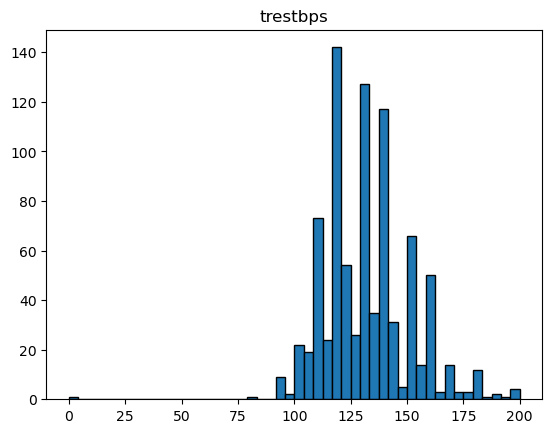

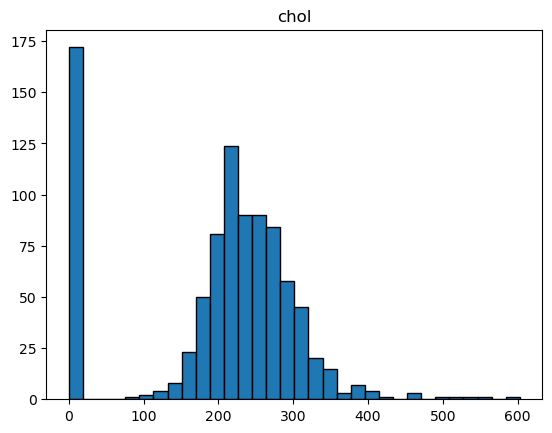

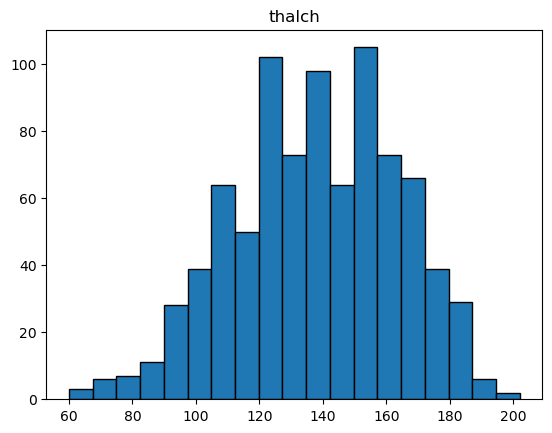

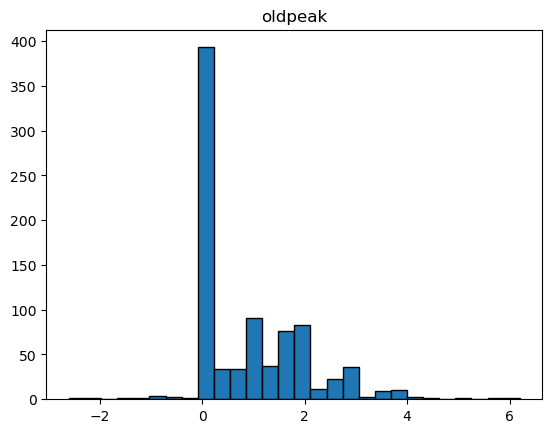

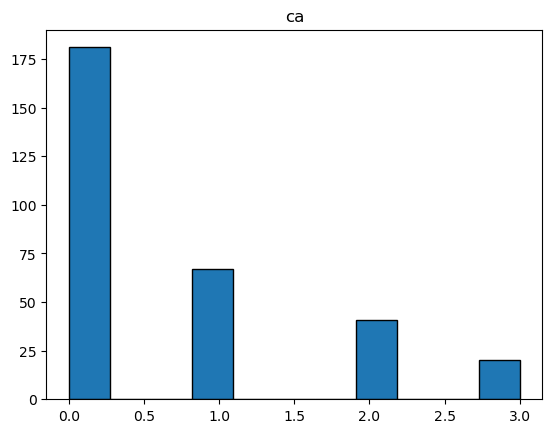

In [6]:
num_col = ['trestbps','chol', 'thalch','oldpeak','ca']
for col in num_col:
    plt.hist(data[col], bins='auto', edgecolor='black')
    plt.title(col)
    plt.show()

## Visualiser Kategoriske Data

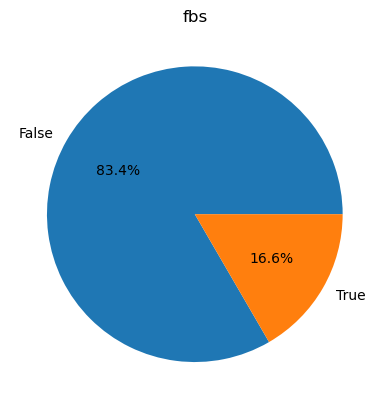

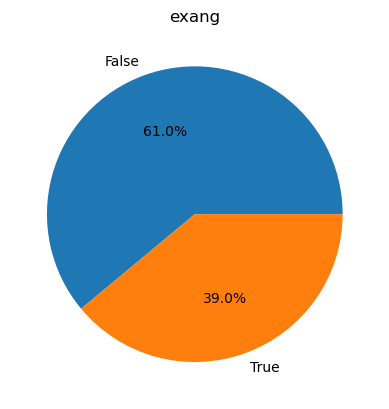

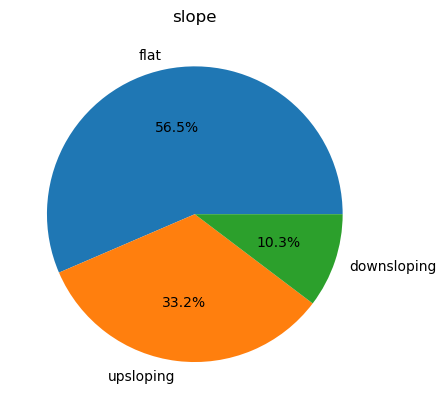

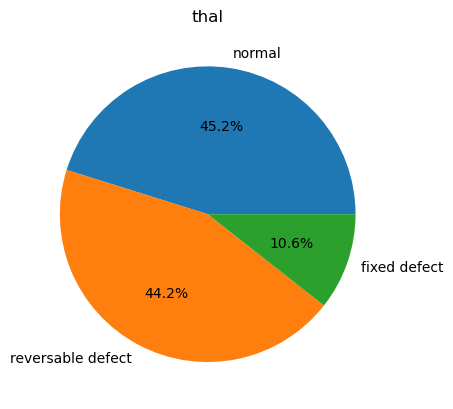

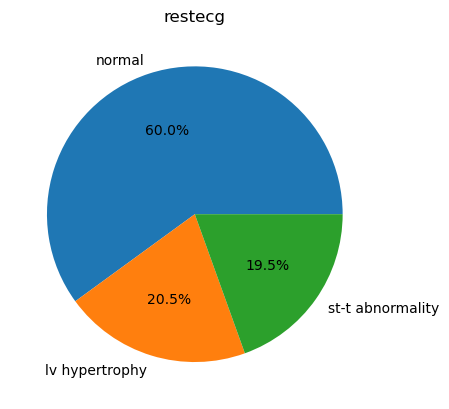

In [7]:
cat_col = ['fbs','exang','slope','thal','restecg']
for col in cat_col:
    catcol_counts = data[col].value_counts()

    plt.pie(catcol_counts.values, labels=catcol_counts.index, autopct='%1.1f%%')

    plt.title(col)

    plt.show()

## Indsæt værdier

Indsætter værdier hvor der er manglende værdier, i stedet for at droppe rows, for at få et større sæt.

exang og fbs er bools så der er det måske bedst at fylde manglende værdier ud med random true/false.

In [8]:
columns_to_impute = ['fbs', 'exang']

for column in columns_to_impute:
    if data[column].isnull().any():
        missing_indices = data[data[column].isnull()].index
        random_values = np.random.choice([True, False], size=len(missing_indices))
        data.loc[missing_indices, column] = random_values

data[columns_to_impute].isna().sum()

fbs      0
exang    0
dtype: int64

slope og thal har mange manglende værdier og mere end 2 kategorier, så derfor kan det være en god ide at tilføje en ny kategori ('NotKnown').

In [9]:
columns_to_impute = ['slope', 'thal']

for column in columns_to_impute:
    if data[column].isnull().any():
        data[column].fillna('NotKnown', inplace=True)

data[columns_to_impute].isna().sum()

slope    0
thal     0
dtype: int64

restecg har kun 2 manglende værdier, så der indsætter vi bare den værdi som der er størst frekvens af i kolonnen('normal')

In [10]:
columns_to_impute = ['restecg']
for column in columns_to_impute:
    if data[column].isnull().any():
        data[column].fillna('normal', inplace=True)

data[columns_to_impute].isna().sum()

restecg    0
dtype: int64

Numeriske manglende værdier kan fyldes ud med gennemsnitsværdien af tilstedeværende værdier.

In [11]:
columns_to_impute = ['trestbps','chol', 'thalch','oldpeak','ca']

for column in columns_to_impute:
    if data[column].isnull().any():
        mean_value = data[column].mean()
        data[column].fillna(mean_value, inplace=True)

data[columns_to_impute].isna().sum()

trestbps    0
chol        0
thalch      0
oldpeak     0
ca          0
dtype: int64

ingen manglende værdier tilbage i sættet, og jeg har ikke droppet nogle rows. Det er brugbart da jeg så har meget mere data at træne modellen ud fra. Datasættet er ikke så stort at jeg bare kan fjerne rows med manglende værdier. 

Hvis datasættet var meget større, kunne det måske være bedre at fjerne i stedet for at indsætte værdier, da indsatte værdier kan give et forvrænget resultat. Dog er det vigtigere i dette tilfælde at have mere data, da sættet er så lille.

In [12]:
data.isna().sum()

age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

## Label Encode Kategoriske Data

Laver kategoriske string data om til numeriske kategorier i stedet, fordi det er bedre at træne modellen med.

In [13]:
for col in data:
    print(col, data[col].dtype)

age int64
sex object
dataset object
cp object
trestbps float64
chol float64
fbs object
restecg object
thalch float64
exang object
oldpeak float64
slope object
ca float64
thal object


In [14]:
data

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,63,Male,Cleveland,typical angina,145.000000,233.0,True,lv hypertrophy,150.000000,False,2.300000,downsloping,0.000000,fixed defect
1,67,Male,Cleveland,asymptomatic,160.000000,286.0,False,lv hypertrophy,108.000000,True,1.500000,flat,3.000000,normal
2,67,Male,Cleveland,asymptomatic,120.000000,229.0,False,lv hypertrophy,129.000000,True,2.600000,flat,2.000000,reversable defect
3,37,Male,Cleveland,non-anginal,130.000000,250.0,False,normal,187.000000,False,3.500000,downsloping,0.000000,normal
4,41,Female,Cleveland,atypical angina,130.000000,204.0,False,lv hypertrophy,172.000000,False,1.400000,upsloping,0.000000,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,Female,VA Long Beach,asymptomatic,127.000000,333.0,True,st-t abnormality,154.000000,False,0.000000,NotKnown,0.676375,NotKnown
916,62,Male,VA Long Beach,typical angina,132.132404,139.0,False,st-t abnormality,137.545665,True,0.878788,NotKnown,0.676375,NotKnown
917,55,Male,VA Long Beach,asymptomatic,122.000000,223.0,True,st-t abnormality,100.000000,False,0.000000,NotKnown,0.676375,fixed defect
918,58,Male,VA Long Beach,asymptomatic,132.132404,385.0,True,lv hypertrophy,137.545665,False,0.878788,NotKnown,0.676375,NotKnown


#### bruger ordinal encoder fra sklean.preprocessing library

In [15]:
enc = OrdinalEncoder()

for col in data:
    if data[col].dtype == 'object':
        data[col] = data[col].astype(str)
        data[col] = enc.fit_transform(data[col].values.reshape(-1, 1))
        
data

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,63,1.0,0.0,3.0,145.000000,233.0,1.0,0.0,150.000000,0.0,2.300000,1.0,0.000000,1.0
1,67,1.0,0.0,0.0,160.000000,286.0,0.0,0.0,108.000000,1.0,1.500000,2.0,3.000000,2.0
2,67,1.0,0.0,0.0,120.000000,229.0,0.0,0.0,129.000000,1.0,2.600000,2.0,2.000000,3.0
3,37,1.0,0.0,2.0,130.000000,250.0,0.0,1.0,187.000000,0.0,3.500000,1.0,0.000000,2.0
4,41,0.0,0.0,1.0,130.000000,204.0,0.0,0.0,172.000000,0.0,1.400000,3.0,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,0.0,3.0,0.0,127.000000,333.0,1.0,2.0,154.000000,0.0,0.000000,0.0,0.676375,0.0
916,62,1.0,3.0,3.0,132.132404,139.0,0.0,2.0,137.545665,1.0,0.878788,0.0,0.676375,0.0
917,55,1.0,3.0,0.0,122.000000,223.0,1.0,2.0,100.000000,0.0,0.000000,0.0,0.676375,1.0
918,58,1.0,3.0,0.0,132.132404,385.0,1.0,0.0,137.545665,0.0,0.878788,0.0,0.676375,0.0


#### Gem i ny csv fil

In [16]:
data.to_csv('data/heart_disease_cleaned.csv', index=False)